In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import re, json, datetime

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

import plotly.express as px
import plotly.graph_objects as go

In [4]:
futures_params = {
    "Si": {"lot": 1, "xrub": 1},
    "RI": {"lot": 1, "xrub": 1.2},
    "GD": {"lot": 1, "xrub": 60},
    "BR": {"lot": 10, "xrub": 60},
}

futures_exp = {"RI": "Z2", 
               "Si": "Z2", 
               "GD": "Z2", 
               "BR": "V2", }

In [5]:
def parse_logs(file_name):
    with open(file_name, 'r') as f:
        n_rows = sum(1 for _ in f)
    raw_data = pd.read_json(file_name, orient='records', lines=True, nrows=n_rows-2)
    
    sdate = re.findall("\d{4}-\d{2}-\d{2}", file_name)[0]
    state = raw_data[raw_data['type'] == 'OnTrade']['state']
    info = raw_data[raw_data['type'] == 'OnTrade']['info']

    # Trades
    state = raw_data[raw_data['type'] == 'OnTrade']['state']
    info = raw_data[raw_data['type'] == 'OnTrade']['info']

    trades = pd.DataFrame()
    trades['bid'] = state.apply(lambda x: x[0])
    trades['ask'] = state.apply(lambda x: x[1])
    trades['mid'] = state.apply(lambda x: x[2])
    trades['Q'] = state.apply(lambda x: x[3])
    trades['direction'] = info.apply(lambda x: x['direction'])
    trades['price'] = info.apply(lambda x: x['price'])
    trades.index = pd.to_datetime(sdate + ' ' + raw_data[raw_data['type'] == 'OnTrade']['time'])
    
    # Orders
    orders = pd.DataFrame()
    state = raw_data[raw_data['type'] == 'SetOrder']['state']
    info = raw_data[raw_data['type'] == 'SetOrder']['info']
    
    orders['bid'] = state.apply(lambda x: x[0])
    orders['ask'] = state.apply(lambda x: x[1])
    orders['mid'] = state.apply(lambda x: x[2])
    orders['Q'] = state.apply(lambda x: x[3])
    orders['direction'] = info.apply(lambda x: x['direction'])
    orders['price'] = info.apply(lambda x: x['price'])
    orders.index = pd.to_datetime(sdate + ' ' + raw_data[raw_data['type'] == 'SetOrder']['time'])
    
    # Quotes
    state = raw_data[raw_data['type'] == 'main']['state']
    info = raw_data[raw_data['type'] == 'main']['info']

    quotes = pd.DataFrame()
    quotes['bid'] = state.apply(lambda x: x[0])
    quotes['ask'] = state.apply(lambda x: x[1])
    quotes['mid'] = state.apply(lambda x: x[2])
    quotes['Q'] = state.apply(lambda x: x[3])
    quotes['asm_bid'] = info.apply(lambda x: x['bid'])
    quotes['asm_ask'] = info.apply(lambda x: x['ask'])
    quotes.index = pd.to_datetime(sdate + ' ' + raw_data[raw_data['type'] == 'main']['time'])
    
    return quotes, orders, trades

In [6]:
def Q_PnL(trades, lot=1, xrub=1, commission=0.47):
    df_pnl = pd.DataFrame()
    
    directions = np.where(trades.direction=='B', 1, -1)
    df_pnl['q_pos'] = np.cumsum(directions)
    df_pnl['cash_pos'] = np.cumsum(-directions * trades.price.to_numpy())
    df_pnl['pnl'] = df_pnl['cash_pos'].to_numpy() + df_pnl['q_pos'].to_numpy() * np.where(df_pnl.q_pos>0, trades.bid, trades.ask)
    df_pnl['pnl'] *= lot*xrub
    df_pnl['pnl_net'] = df_pnl['pnl'].to_numpy() - commission*np.arange(1, df_pnl.shape[0]+1)
    
    df_pnl.index = trades.index
    return df_pnl

In [7]:
def get_stat(ticker, month, log_prefix='c:/QUIK-Test/scripts/logs/', lot=1, xrub=1):
    date = datetime.datetime.strftime(datetime.date.today(), "%Y-%m-%d")
    file_name = f"{log_prefix}AS-model_{ticker}{month}_{date}.log"
    
    quotes, orders, trades = parse_logs(file_name)
    counts = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count()    
    
    pnl = Q_PnL(trades, lot=lot, 
            xrub=xrub, 
            commission=0.47)
    
    return pnl['pnl'][-1], pnl['pnl_net'][-1], pnl.shape[0], np.max(counts)

In [29]:
# Monitoring
print(f"Ticker\t#deals\tPnL\tPnL/1\tPnL net\tMax #order")
for ticker in futures_params:
    pnl_gross, pnl_net, pnl_count, max_cnt = get_stat(ticker, futures_exp[ticker], 
                                                      lot=futures_params[ticker]['lot'],
                                                      xrub=futures_params[ticker]['xrub'])
    print(f"{ticker}\t{pnl_count:d}\t{pnl_gross:0.1f}\t{pnl_gross/pnl_count:0.2f}\t{pnl_net:0.1f}\t{max_cnt:.0f}")

Ticker	#deals	PnL	PnL/1	PnL net	Max #order
Si	4617	5103.0	1.11	2933.0	4
RI	1876	11280.0	6.01	10398.3	4
GD	626	8520.0	13.61	8225.8	4
BR	546	1866.0	3.42	1609.4	3


In [39]:
ticker = "BR"
date = datetime.datetime.strftime(datetime.date.today(), "%Y-%m-%d")
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}{futures_exp[ticker]}_{date}.log"

quotes, orders, trades = parse_logs(logfile)
counts = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count() * 2

In [40]:
pnl = Q_PnL(trades, lot=futures_params[ticker]["lot"], 
            xrub=futures_params[ticker]["xrub"], 
            commission=0.47)

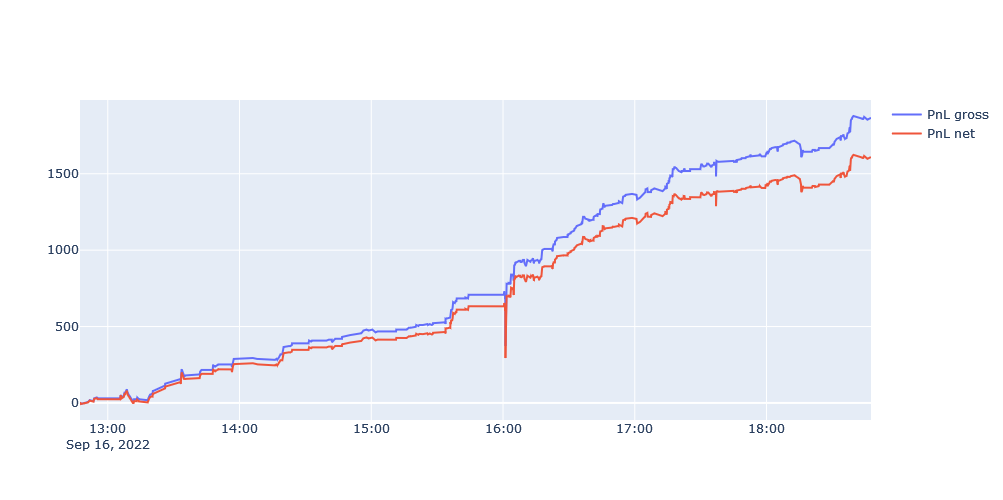

In [41]:
# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=pnl.index, y=pnl.pnl,
                    mode='lines',
                    name='PnL gross'))
fig.add_trace(go.Scatter(x=pnl.index, y=pnl.pnl_net,
                    mode='lines',
                    name='PnL net'))

fig.update_layout(width=1000, height=500)

fig.show()

In [122]:
ticker = "Si"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_{date}.log"
quotes, orders, trades = parse_logs(logfile)
counts = (orders['Q'].rolling(window=datetime.timedelta(seconds=1))
          .count()
          .groupby(level=0)
          .sum()) * 2

ticker = "RI"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_{date}.log"
quotes, orders, trades = parse_logs(logfile)
z = (orders['Q'].rolling(window=datetime.timedelta(seconds=1))
          .count()
          .groupby(level=0)
          .sum()) * 2
counts = counts.add(z, fill_value=0)

ticker = "GD"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_{date}.log"
quotes, orders, trades = parse_logs(logfile)
z = (orders['Q'].rolling(window=datetime.timedelta(seconds=1))
          .count()
          .groupby(level=0)
          .sum()) * 2
counts = counts.add(z, fill_value=0)

ticker = "BR"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_{date}.log"
quotes, orders, trades = parse_logs(logfile)
z = (orders['Q'].rolling(window=datetime.timedelta(seconds=1))
          .count()
          .groupby(level=0)
          .sum()) * 2
counts = counts.add(z, fill_value=0)

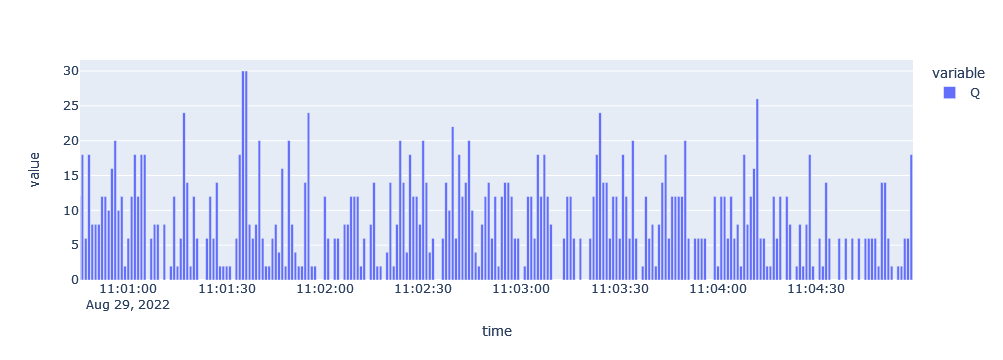

In [134]:
px.bar(counts)

In [140]:
counts[350:]

time
2022-08-29 11:00:27    12.0
2022-08-29 11:00:28     6.0
2022-08-29 11:00:30     6.0
2022-08-29 11:00:31    22.0
2022-08-29 11:00:32     8.0
                       ... 
2022-08-29 17:03:41     2.0
2022-08-29 17:03:43     2.0
2022-08-29 17:03:44     2.0
2022-08-29 17:03:46     6.0
2022-08-29 17:03:47     6.0
Name: Q, Length: 14955, dtype: float64